In [1]:
%reload_kedro

/home/tdenimal/miniconda3/envs/particles/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2020-09-14 12:06:44,325 - root - INFO - ** Kedro project particles
2020-09-14 12:06:44,328 - root - INFO - Defined global variable `context` and `catalog`
2020-09-14 12:06:44,335 - root - INFO - Registered line magic `run_viz`


In [25]:
#Load libraries
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import lightgbm

import numpy as np

In [3]:
print(lightgbm.__version__)

3.0.0


/home/tdenimal/miniconda3/envs/particles/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
csv_raw = context.catalog.load("csv_raw") 

2020-09-14 12:06:58,681 - kedro.io.data_catalog - INFO - Loading data from `csv_raw` (CSVDataSet)...


In [5]:
train,test = train_test_split(csv_raw, test_size=.2, random_state = 42, stratify=csv_raw["BAD"])

# EDA

In [6]:
train.head(5)

/home/tdenimal/miniconda3/envs/particles/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
609,0,7700,70451.00,81862.0,DebtCon,Sales,3.0,0.0,0.0,141.268671,0.0,31.0,31.681943
4015,1,21000,48735.00,71694.0,DebtCon,Other,8.0,0.0,0.0,48.498971,3.0,10.0,32.921401
1591,0,11500,63136.00,81099.0,DebtCon,Other,3.0,NaN,NaN,149.064745,NaN,35.0,28.975940
1127,0,9900,55342.00,72357.0,DebtCon,Mgr,7.0,NaN,3.0,111.998855,1.0,11.0,39.870340
920,0,9000,47350.86,105000.0,DebtCon,ProfExe,6.0,0.0,1.0,227.266667,0.0,10.0,NaN


/home/tdenimal/miniconda3/envs/particles/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


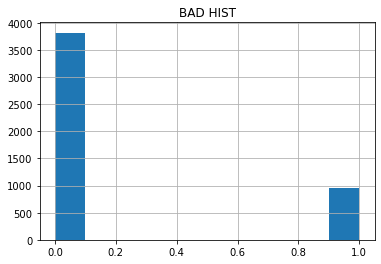

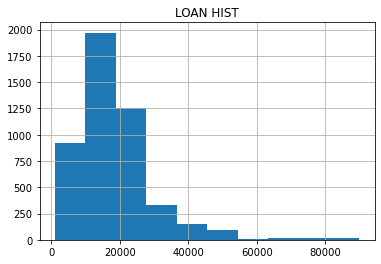

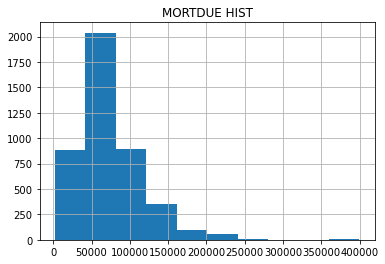

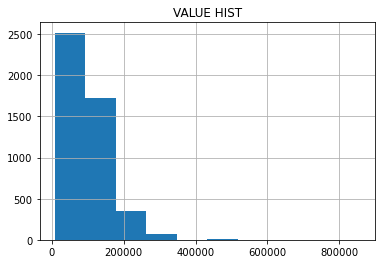

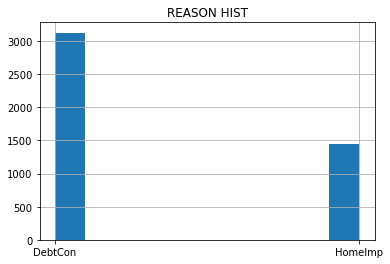

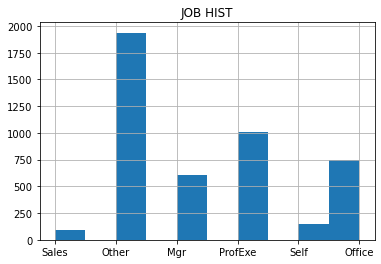

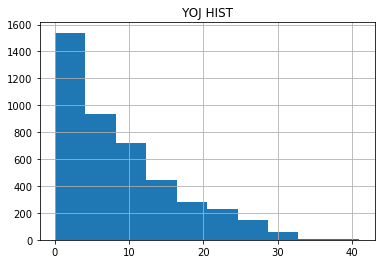

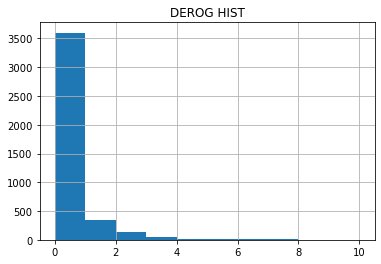

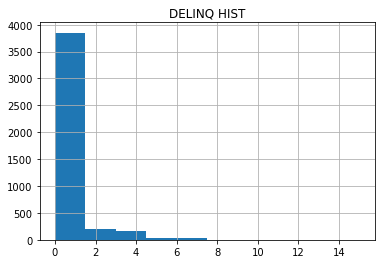

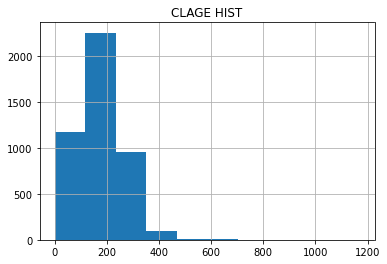

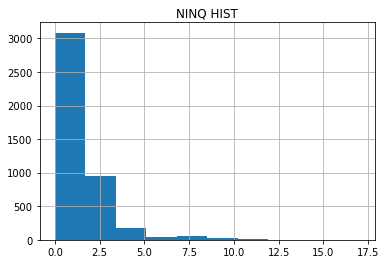

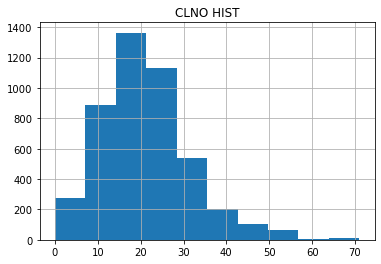

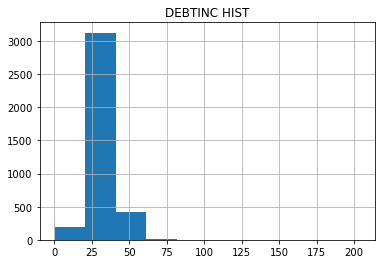

In [7]:
#Check distributions
for col in train.columns:
    plt.title(col+" HIST")
    train[col].hist()
    plt.show()

In [8]:
#Check for nan/undefined values
for col in train.columns:
    na_pct = train[train[col].isna()].shape[0] / train.shape[0]
    print(f"column {col} - nan_pct = {na_pct}")

column BAD - nan_pct = 0.0
column LOAN - nan_pct = 0.0
column MORTDUE - nan_pct = 0.08829697986577181
column VALUE - nan_pct = 0.018666107382550336
column REASON - nan_pct = 0.04089765100671141
column JOB - nan_pct = 0.04823825503355705
column YOJ - nan_pct = 0.08452181208053691
column DEROG - nan_pct = 0.12332214765100671
column DELINQ - nan_pct = 0.09899328859060402
column CLAGE - nan_pct = 0.05432046979865772
column NINQ - nan_pct = 0.08682885906040269
column CLNO - nan_pct = 0.03859060402684564
column DEBTINC - nan_pct = 0.21078020134228187


In [ ]:
#For columns MORTDUE, VALUE,

# DATA ENGINEERING PIPELINE

In [9]:
train["REASON"] = train["REASON"].astype('category')
train["JOB"] = train["JOB"].astype('category')


test["REASON"] = test["REASON"].astype('category')
test["JOB"] = test["JOB"].astype('category')

/home/tdenimal/miniconda3/envs/particles/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/tdenimal/miniconda3/envs/particles/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/tdenimal/miniconda3/envs/particles/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [10]:
categorical_features = ["DEROG","DELINQ","JOB","REASON"]

train_ds = lightgbm.Dataset(train[[col for col in train.columns if col != "BAD"]],
                            label=train["BAD"], 
                            categorical_feature=categorical_features,
                           free_raw_data=False)

test_ds = lightgbm.Dataset(test[[col for col in test.columns if col != "BAD"]],
                           label=test["BAD"])

# DATA SCIENCE PIPELINE

In [38]:
#DS Lightgbm

parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}


model_cv = lightgbm.cv(parameters,
                       train_ds,
                       nfold=20,
                       stratified=True,
                       num_boost_round=5000,
                       early_stopping_rounds=100,
                       return_cvbooster=True)

# model = lightgbm.train(parameters,
#                        train_ds,
#                        valid_sets=test_ds,
#                        num_boost_round=5000,
#                        early_stopping_rounds=100)


[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Curr

/home/tdenimal/miniconda3/envs/particles/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing w

In [39]:
#Retrieve model
models = model_cv["cvbooster"]
model = models.boosters[19]

/home/tdenimal/miniconda3/envs/particles/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


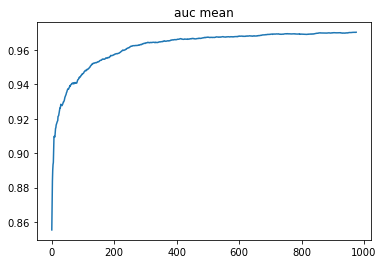

In [53]:
#Plot metric mean value
plt.title("auc mean")
plt.plot(model_cv["auc-mean"])
plt.show()

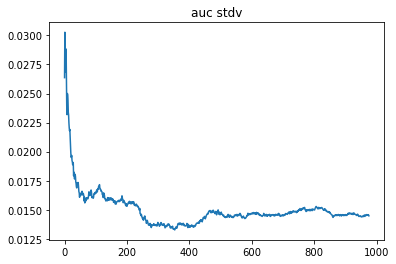

In [55]:
#PLot std of metric mean
plt.title("auc stdv")
plt.plot(model_cv["auc-stdv"])
plt.show()

In [40]:
#Pred prob binary
pred_proba = model.predict(test[[col for col in test.columns if col != "BAD"]])

In [41]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test["BAD"], pred_proba, pos_label=1)
metrics.auc(fpr, tpr)

0.9658580413297393